# Projet 9 : Prédisez la demande en électricité


# Scénario



# Prérequis

Pour effectuer ce projet, vous devrez maîtriser la manipulation de données en Python ou R, connaître la modélisation de type régression linéaire, ainsi que les différentes modélisations de séries temporelles (AR, MA, ARMA, ARIMA, etc.)

# Mise en situation

Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.

La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !

Les données
Vous téléchargerez les données mensuelles de consommation totale d'électricité en énergie à partir de cette page.

Les données météo que vous utiliserez pour corriger les données de l'effet température sont présentes ici : https://cegibat.grdf.fr/simulateur/calcul-dju

# Vos missions
Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.
Pour chaque traitement effectué (correction de l'effet température, désaisonnalisation, etc.), vous présenterez les 2 séries temporelles avant et après traitement, sur un graphique où les deux séries temporelles seront superposées.

In [100]:
# importation des libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as st
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format','{:.3f}'.format)
%matplotlib inline 

# Données conso :


Les données sont téléchargées sur :


https://www.rte-france.com/eco2mix/telecharger-les-indicateurs

# Description des données

https://assets.rte-france.com/prod/public/2020-07/%C3%A9CO2mix%20-%20Description%20des%20fichiers%20des%20donn%C3%A9es%20en%20%C3%A9nergie.pdf

In [101]:
# importation csv file
data = pd.read_excel("data.xlsx")
df=pd.DataFrame(data)
df.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.000,5399,741.000,691,3967,6741,...,514,51086,5371.000,7043.000,1672.000,929.000,724.000,1581.000,2195.000,-59.000
1,2012-02,Données définitives,France,54419,38661.000,8721,2511.000,1309,4901,5244,...,454,54476,-715.000,4504.000,5220.000,-798.000,-309.000,1244.000,1579.000,-2430.000
2,2012-03,Données définitives,France,48583,37549.000,5276,1435.000,666,3175,3894,...,531,43156,4888.000,7042.000,2153.000,583.000,330.000,1742.000,2235.000,-1.000
3,2012-04,Données définitives,France,44192,33100.000,3484,1655.000,486,1343,5302,...,405,40176,3447.000,5762.000,2314.000,547.000,-9.000,1271.000,1670.000,-31.000
4,2012-05,Données définitives,France,40433,29058.000,1772,854.000,368,549,7706,...,469,35257,4425.000,6391.000,1965.000,693.000,251.000,1341.000,1060.000,1079.000


In [102]:
# 5 dernières lignes

df.tail()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
1398,2021-11,Données consolidées,Occitanie,2142,897.000,59,NaN,0,59,638,...,60,3581,-1608.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1399,2021-11,Données consolidées,Normandie,5376,4929.000,239,-1.000,31,208,5,...,58,2528,2848.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400,2021-11,Données consolidées,Hauts-de-France,4319,2265.000,1239,0.000,5,1233,1,...,80,4593,-273.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1401,2021-11,Données consolidées,PACA,1745,NaN,847,-1.000,20,828,712,...,61,3561,-1821.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1402,2021-11,Données consolidées,Pays-de-la-Loire,940,NaN,700,328.000,3,369,0,...,40,2607,-1667.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# description data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Mois                                      1403 non-null   object 
 1   Qualité                                   1403 non-null   object 
 2   Territoire                                1403 non-null   object 
 3   Production totale                         1403 non-null   int64  
 4   Production nucléaire                      913 non-null    float64
 5   Production thermique totale               1403 non-null   int64  
 6   Production thermique charbon              974 non-null    float64
 7   Production thermique fioul                1403 non-null   int64  
 8   Production thermique gaz                  1403 non-null   int64  
 9   Production hydraulique                    1403 non-null   int64  
 10  Production éolien                   

Notre dataframe ne contient pas de données nulles.

In [104]:
df.describe(include="all")

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
count,1403,1403,1403,1403.000,913.000,1403.000,974.000,1403.000,1403.000,1403.000,...,1403.000,1403.000,1316.000,119.000,119.000,119.000,119.000,119.000,119.000,106.000
unique,119,2,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-08,Données définitives,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,13,1104,119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,7159.502,7974.184,534.991,166.092,32.577,395.556,855.679,...,115.659,6005.314,700.907,6918.555,2674.882,957.193,618.756,1471.084,1144.655,163.660
std,NaN,NaN,NaN,11956.379,9812.768,1064.199,342.282,83.621,803.936,1576.320,...,186.335,10569.470,3150.792,1500.596,1091.238,504.539,681.988,439.786,589.635,1267.125
min,NaN,NaN,NaN,92.000,26.000,-3.000,-10.000,-4.000,-1.000,0.000,...,7.000,0.000,-7949.000,658.000,-1111.000,-798.000,-1005.000,109.000,-322.000,-2912.000
25%,NaN,NaN,NaN,554.500,2732.000,33.000,0.000,0.000,18.000,5.000,...,36.000,1809.500,-1492.000,6156.500,2077.500,730.000,179.000,1200.500,670.500,-574.000
50%,NaN,NaN,NaN,3654.000,4948.000,172.000,18.000,5.000,125.000,67.000,...,61.000,2961.000,0.000,7101.000,2483.000,1059.000,637.000,1514.000,1236.000,183.000
75%,NaN,NaN,NaN,7127.000,7139.000,534.000,187.000,20.000,369.000,842.500,...,92.000,4515.000,3615.250,7893.000,3292.000,1301.500,1156.500,1785.500,1558.000,933.250


13 valeurs uniques pour les territoires

In [105]:
df["Territoire"].unique()

array(['France', 'Grand-Est', 'Nouvelle-Aquitaine',
       'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Ile-de-France', 'Occitanie', 'Normandie',
       'Hauts-de-France', 'PACA', 'Pays-de-la-Loire'], dtype=object)

12 régions de France y sont représentées ainsi que l'agglomérat au niveau national.

In [106]:
#Afin de coller avec les données DJU nous allons concentrer l'étude sur France
# choisir France dans le colonne Territoire

df = df.loc[df['Territoire'] == 'France']


#Les colonnes qui nous intéressent désormais sont la date et la conso : 

df = df[['Mois', 'Consommation totale']]


#Les données DJU vont jusqu'au 06/2021 et pour lequelle on va choissir les dates avant 06/2021 dans dataframe où est consomation:

df = df.loc[df['Mois'] < "2021-06"]

#On renomme les colonnes : 

df = df.rename(columns={'Mois':'date', 'Consommation totale':'consommation'})

#On convertie ensuite la date en datetime :

from datetime import datetime

df['date'] = df['date'].astype('datetime64[ns]')

#Set index sur date : 

df = df.set_index('date')

df.head()

,consommation
date,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257


In [107]:
# sort values 

df.sort_values(by='date')

,consommation
date,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257
...,...
2021-01-01,52983
2021-02-01,43024
2021-03-01,43913


In [108]:
# verification des valeurs manquantes

df.isna().sum()

consommation    0
dtype: int64

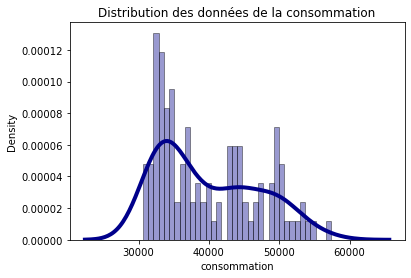

In [109]:
# Density Plot and Histograme
sns.distplot(df['consommation'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('Distribution des données de la consommation')
plt.savefig("P9_02_graphics/histogramme.jpeg")

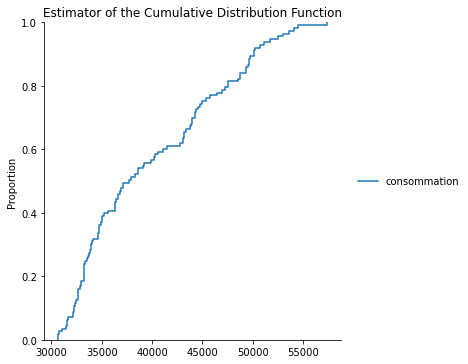

In [110]:
# ecdf - precentage des données

sns.displot(data=df, kind="ecdf")
plt.title('Estimator of the Cumulative Distribution Function')
plt.savefig("P9_02_graphics/ecdf.jpeg")

# Représentation de la série temporelle - consommation de electricité

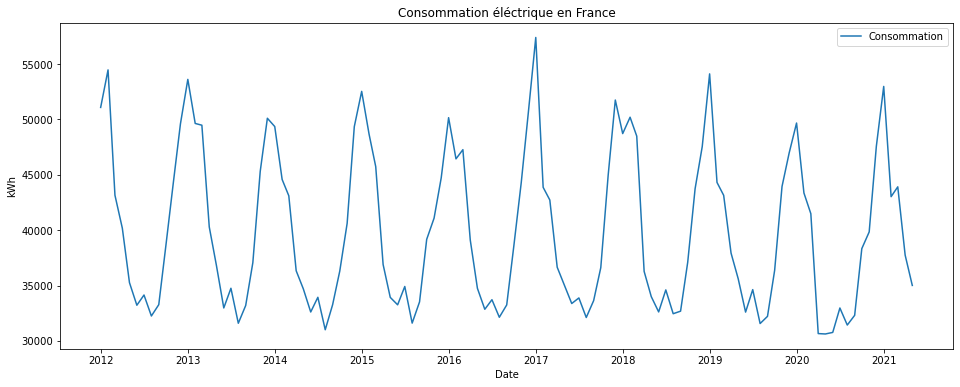

In [111]:
#Représentation des données - consomation
plt.figure(figsize=(16,6))
plt.plot(df, label='Consommation')
plt.title("Consommation éléctrique en France")
plt.ylabel("kWh")
plt.xlabel("Date")
plt.legend()
plt.savefig("P9_02_graphics/donnée-Brut.jpeg")
plt.show()

On voit que pendant des année 2015 et 2017 , nous avons plus consomation.

Ici les effets de la saison semblent très marqués.

On peut voir ici que nos consommations ont de grosse augmentation en hiver, due au chauffage électrique entre autres.

# Données DJU


Données téléchargées sur :

https://cegibat.grdf.fr/simulateur/calcul-dju

Données effet température


Le degré jour est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli (18°C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

2 méthodes de calculs sont proposées : Météo (méthode simplifiée) et Professionnels de l’énergie (méthode plus complexe pour mieux prendre en compte les débuts et fins de saisons de chauffe/climatisation)

In [112]:
# importation csv file avec des données DJU

df2 = pd.read_csv('data.csv')

In [113]:
df2.head()

,date,Chauffage
0,2009-01-01,373.312
1,2009-02-01,293.575
2,2009-03-01,247.175
3,2009-04-01,157.025
4,2009-05-01,86.987


In [114]:
# info de notre dataframe

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       156 non-null    object 
 1   Chauffage  156 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [115]:
# chagment de type le colonne date
df2['date'] = df2['date'].astype('datetime64[ns]')

In [116]:
# verification type de index
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       156 non-null    datetime64[ns]
 1   Chauffage  156 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.6 KB


In [117]:
#On enlève les valeurs après Juin 2021 : 
df2 = df2[df2.date < "2021-06"]

In [118]:
# visulation de dataframe
df2.head()

,date,Chauffage
0,2009-01-01,373.312
1,2009-02-01,293.575
2,2009-03-01,247.175
3,2009-04-01,157.025
4,2009-05-01,86.987


In [119]:
# sort values et set index
df2= df2.sort_values(by='date')
df2.set_index("date", inplace=True)

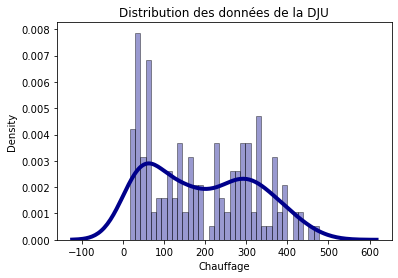

In [120]:
# Density Plot and Histogram of all arrival delays
sns.distplot(df2['Chauffage'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


plt.title('Distribution des données de la DJU')
plt.savefig("P9_02_graphics/histogrammeDJU.jpeg")

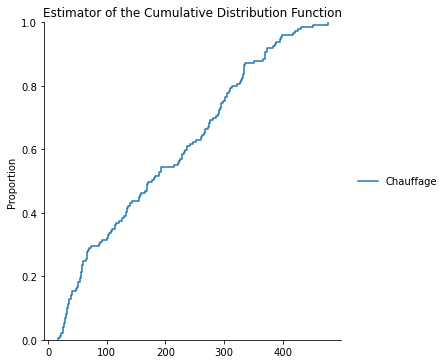

In [121]:
# ecdf - precentage des données

sns.displot(data=df2, kind="ecdf")
plt.title('Estimator of the Cumulative Distribution Function')
plt.savefig("P9_02_graphics/ecdf-DJU.jpeg")

# Représentation de la série temporelle - DJU

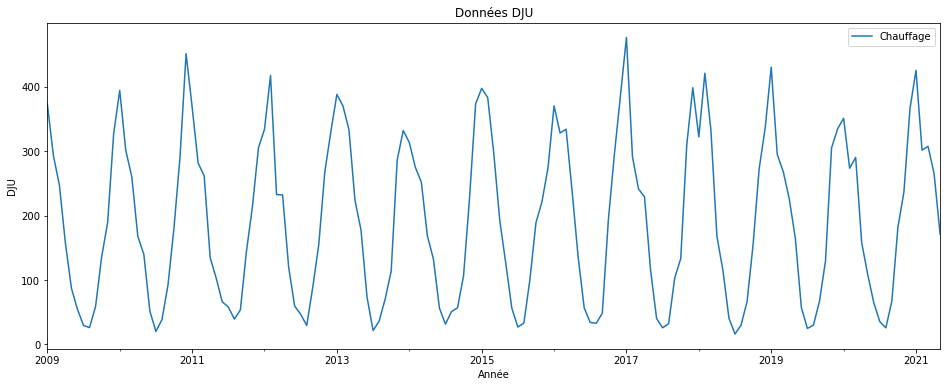

In [122]:
df2.plot(y='Chauffage', figsize=[16,6])
plt.xlabel('Année')
plt.ylabel('DJU')
plt.title('Données DJU')
plt.savefig("P9_02_graphics/donnéedju.jpeg")
plt.show()

# Test statistiques

Plus la valeur de p est petite, plus la probabilité de faire une erreur en rejetant l'hypothèse nulle est faible. Une valeur limite de 0,05 est souvent utilisée. Autrement dit, vous pouvez rejeter l'hypothèse nulle si la valeur de p est inférieure à 0,05.

Mais avant de nous lancer dans nos prédictions, testons notre série temporelle, dans l'étude des séries temporelles la stationnarité de la série est importante.

In [123]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, consommation):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[consommation].rolling(window = 12, center = False).mean()
    rolstd = df[consommation].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[consommation], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(consommation))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[consommation], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    

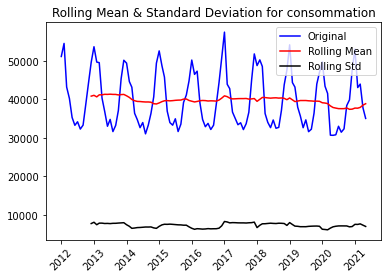

Results of Dickey-Fuller Test:
Test Statistic                 -1.674
p-value                         0.445
# Lags Used                    11.000
Number of Observations Used   101.000
Critical Value (1%)            -3.497
Critical Value (5%)            -2.891
Critical Value (10%)           -2.582
dtype: float64


In [124]:
test_stationarity(df = df, consommation= 'consommation')



In [125]:

from statsmodels.tsa.stattools import adfuller
def test_stationarity(df2, Chauffage):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df2[Chauffage].rolling(window = 12, center = False).mean()
    rolstd = df2[Chauffage].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df2[Chauffage], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(Chauffage))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df2[Chauffage], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

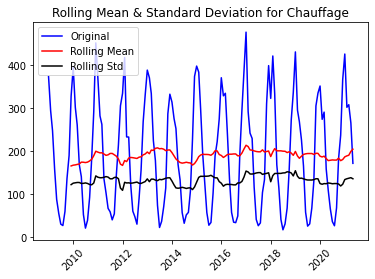

Results of Dickey-Fuller Test:
Test Statistic                 -3.264
p-value                         0.017
# Lags Used                    14.000
Number of Observations Used   134.000
Critical Value (1%)            -3.480
Critical Value (5%)            -2.883
Critical Value (10%)           -2.578
dtype: float64


In [126]:

test_stationarity(df2 = df2,Chauffage= 'Chauffage')

# Mission 1 : Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

In [127]:
all_data = pd.merge(df, df2, left_index=True, right_index=True)

In [128]:
all_data

,consommation,Chauffage
date,,
2012-01-01,51086,334.038
2012-02-01,54476,417.650
2012-03-01,43156,232.550
2012-04-01,40176,232.213
2012-05-01,35257,120.312
...,...,...
2021-01-01,52983,425.688
2021-02-01,43024,301.613
2021-03-01,43913,307.600


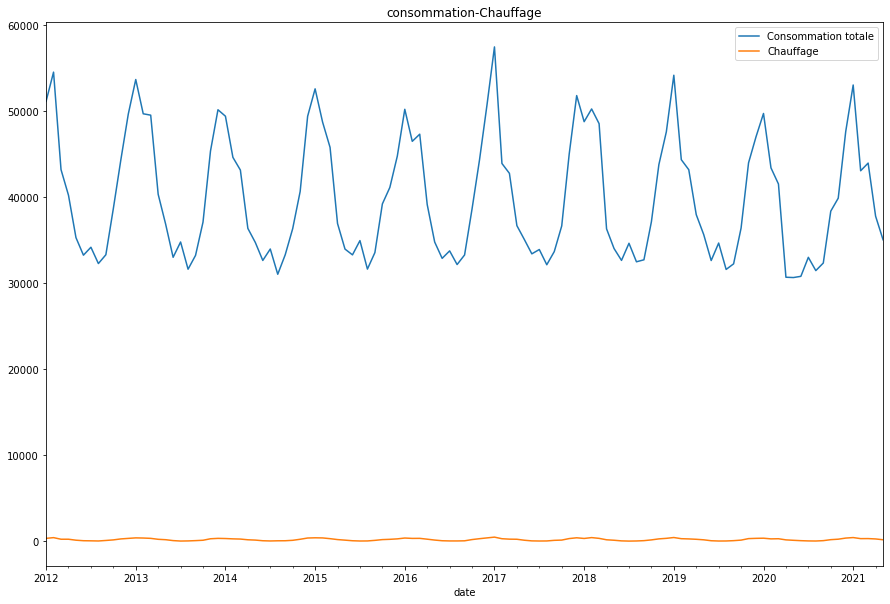

In [129]:
# visulation consomation et DJU ensamble
all_data['consommation'].plot(label='Consommation totale', figsize=(15,10))
all_data['Chauffage'].plot(label='Chauffage')
plt.title('consommation-Chauffage')
plt.savefig("P9_02_graphics/consommation-Chauffage.jpeg")
plt.legend()

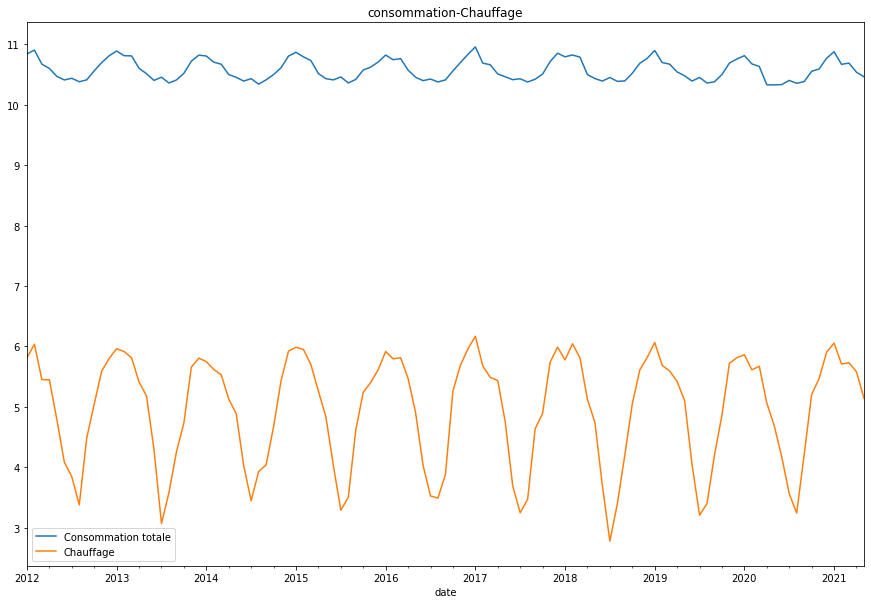

In [130]:

np.log(all_data['consommation']).plot(label='Consommation totale', figsize=(15,10))
np.log(all_data['Chauffage']).plot(label='Chauffage')
plt.title('consommation-Chauffage')
plt.savefig("P9_02_graphics/consommation-Chauffage-log.jpeg")
plt.legend()

Les 2 courbes semblent suivre la même saisonnalité.

Les variations de la courbe de consommation d'énergie sont effectivement globalement liées aux écarts de températures.

# Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
Désaisonnaliser

In [131]:

all_data['t'] = range(1, all_data.shape[0] +1)
y = all_data['consommation']
X = all_data.drop('consommation',axis=1)

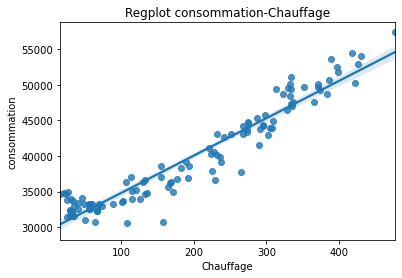

In [132]:
# creation regplot que nous pouvons voir relation linaire
sns.regplot(x="Chauffage", y="consommation", data=all_data)
plt.title('Regplot consommation-Chauffage')
plt.savefig("P9_02_graphics/regplot.jpeg")


Nous projetons les donnees ainsi
X= Chauffage
y = consommation d'énergie

Dans ce modèle, nous supposons qu'il existe une rélation linéaire entre la variable à expliquer et la variables explicative:


Y= α + bx +ε

Nous cherchons donc les paramètres inconnus α et b pour corriger les consommations mensuelles de l'effet de température.

In [133]:
# visulation des données
all_data.head()

,consommation,Chauffage,t
date,,,
2012-01-01,51086,334.038,1
2012-02-01,54476,417.650,2
2012-03-01,43156,232.550,3
2012-04-01,40176,232.213,4
2012-05-01,35257,120.312,5


In [134]:
from sklearn import linear_model

reg_lin = linear_model.LinearRegression(fit_intercept=True)
reg_fit = reg_lin.fit(X,y)

In [135]:
# coefficient de correction

coeff0 = reg_fit.coef_[0]
print(coeff0)

52.68952142592793


In [136]:
inter=reg_fit.intercept_

Les coefficients de régressions sont ici estimés.

In [137]:
print(coeff0,inter)
#Ici nous avons le coefficient du dju et le 2ème coeff correspond à t=temps
#les coeff sont affichés ds cette ordre puisque ils sont ds cet ordre ds le dataset

52.68952142592793 30862.309670338007


In [138]:
ts_corr = all_data['consommation'] - all_data['Chauffage']*coeff0 

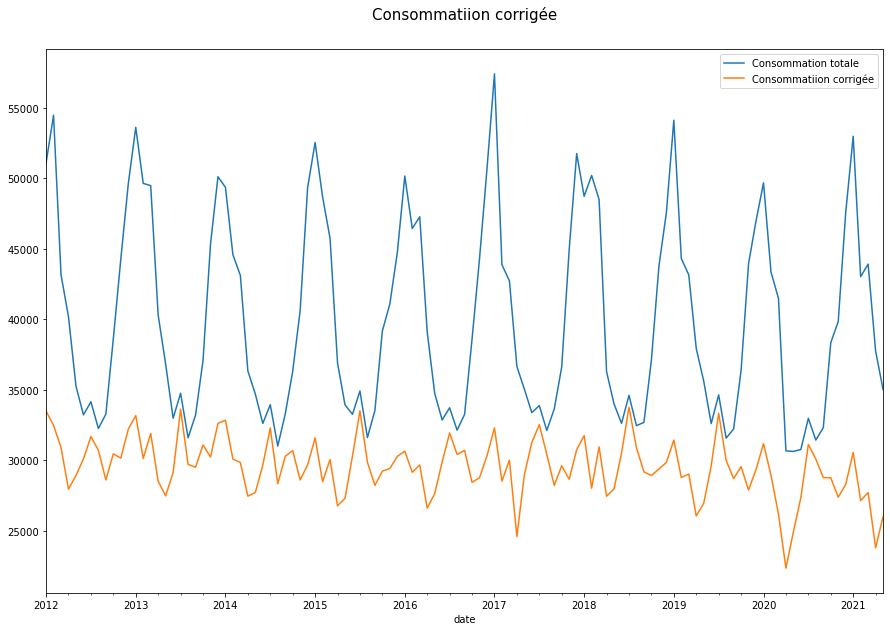

In [139]:
all_data['consommation'].plot(label='Consommation totale', figsize=(15,10))
ts_corr.plot(label='Consommatiion corrigée')
plt.title('Consommatiion corrigée', fontsize=15, pad=30)
plt.savefig("P9_02_graphics/Consommatiion corrigée.jpeg")
plt.legend()

La correction a  eu un grand impact sur nos données à cause de désaisonnalisation. Donc nous pouvons dire qu'il y a clairement l'impact des chauffage sur les consommation d'énergie au niveau national.


Les tests sur notre modèles de régression linéaire étant significatifs, nous allons pouvoir utiliser les coefficients obtenus pour corriger notre consommation d'énergie des effets de la température:

Conso(ajustée) = Conso -(DJU*b)





In [140]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [141]:
# visulation serie corriger
ts_corr

date
2012-01-01   33485.724
2012-02-01   32470.221
2012-03-01   30903.052
2012-04-01   27940.835
2012-05-01   28917.792
                ...   
2021-01-01   30553.729
2021-02-01   27132.182
2021-03-01   27705.703
2021-04-01   23786.911
2021-05-01   25999.068
Length: 113, dtype: float64

In [142]:
all_data.iloc[107]

consommation   47565.000
Chauffage        365.975
t                108.000
Name: 2020-12-01 00:00:00, dtype: float64

In [143]:
# avec iloc je vais selecter des données jusqu'à 2020
all_data.iloc[108]

consommation   52983.000
Chauffage        425.688
t                109.000
Name: 2021-01-01 00:00:00, dtype: float64

In [144]:
reg_simp = smf.ols('consommation~Chauffage+t', data=all_data).fit()
print(reg_simp.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     694.8
Date:                Sat, 19 Feb 2022   Prob (F-statistic):           3.96e-63
Time:                        22:24:44   Log-Likelihood:                -1013.9
No. Observations:                 113   AIC:                             2034.
Df Residuals:                     110   BIC:                             2042.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.086e+04    455.871     67.700      0.0

On voit que tous les paramètres sont significatifs et que le R² est à 0.925, le modèle est donc satisfaisant.
La température explique 92% de la consommation.

Et au vu de la représantation graphique de notre droite de régression, cela nous indique que le modèle est perfomant.

La variable "Chauffage" est également statistiquement signifivative au niveau de test 5 %, sa p-value étant 0.

In [145]:
ts_corr=ts_corr.iloc[:108]

In [146]:
serie_corr_deseasonal = pd.DataFrame({'date':ts_corr.index, 'donnees_corriges':ts_corr.values})

In [147]:
serie_corr_deseasonal

,date,donnees_corriges
0,2012-01-01,33485.724
1,2012-02-01,32470.221
2,2012-03-01,30903.052
3,2012-04-01,27940.835
4,2012-05-01,28917.792
...,...,...
103,2020-08-01,30082.441
104,2020-09-01,28766.264
105,2020-10-01,28754.362
106,2020-11-01,27372.342


In [148]:
# test de normalité

from scipy.stats import shapiro
shapiro(reg_simp.resid)


ShapiroResult(statistic=0.9911978840827942, pvalue=0.6858147978782654)

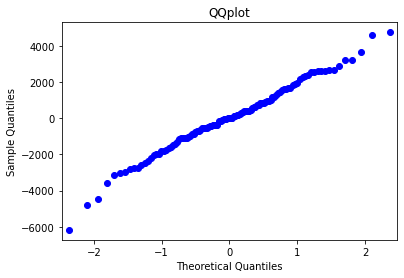

In [149]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(reg_simp.resid)

plt.title("QQplot")
plt.savefig("P9_02_graphics/QQplot.jpeg")

plt.show()

Les points projetés sont proche de la première bissectrice, ce qui nous indique que les valeurs ajustées sont proche des valeurs réelles.

La normalité des résidus est conformée avec la distribution observée et le QQplot. Le test de Shapiro indique une p-value de 0.68.

# Désaisonnaliser grâce aux moyennes mobiles

# Mission 2


Effectuez une désaisonnalisation de la consommation que vous aurez obtenu après correction, grâce aux moyennes mobiles.

Nous voulons à présent venir de bout de l'effet de saison qui habite nos données.

Nos données varient en suivant un cycle prévisible, ici une période de l'année, par exemple en hiver, nos données ont une tendance à augmenter, c'est qu'on appelle une saisonnalité au sein des données.


La correction des variations saisonnières ( CVS) est une technique empoloyée pour éliminer l'effet des fluctuations saisonnières normales sur les données, de manière à en faire ressortir les tendances fondamentales.


Une moyenne mobile est une combinaison linéaire d'instants passés et futurs de notre série temporelle. L'enjeu est de trouver une moyenne mobile qui laisse la tendance invariante, qui absorbe la saisonnalité et qui réduit le résidu:

Notre série temporelle : Xt = Tt + St+ εt

Si on applique une moyenne mobile M sur la série  nous obtenons :

MXt  = MTt + MSt + Mεt

Ses propriétés idéales seront donc :

MTt = Tt
MSt = 0
Mεt faible


In [150]:
ts_corr.to_csv("data_corriges")

In [151]:
serie_corr_deseasonal.tail(n=8)

,date,donnees_corriges
100,2020-05-01,24912.432
101,2020-06-01,27348.719
102,2020-07-01,31114.012
103,2020-08-01,30082.441
104,2020-09-01,28766.264
105,2020-10-01,28754.362
106,2020-11-01,27372.342
107,2020-12-01,28281.952


# Decomposition

La décomposition des séries temporelles fait référence à la méthode par laquelle nous réduisons nos données de séries temporelles en ses quatre composantes suivantes : La tendance d'une série chronologique fait référence à la direction générale dans laquelle la série chronologique évolue. Les séries chronologiques peuvent avoir une tendance positive ou négative, mais peuvent aussi ne pas avoir de tendance.



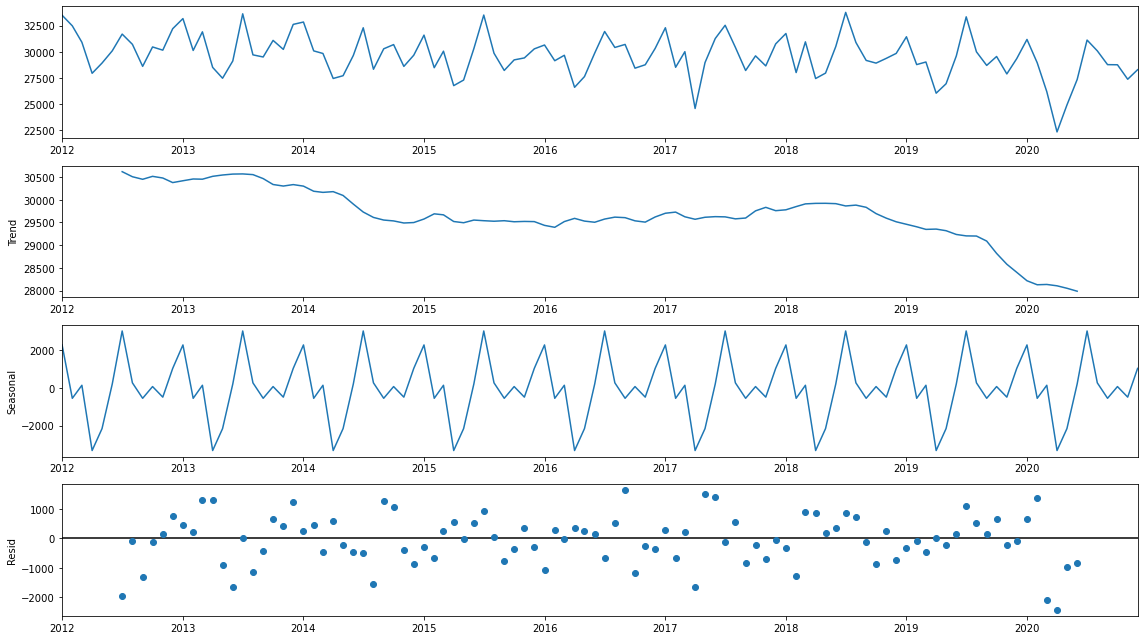

In [152]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomp = seasonal_decompose(ts_corr, model='additif')

#dataviz
fig = decomp.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.savefig("P9_02_graphics/decomposition_data.jpeg")

plt.show()


Le premier graphics montre notre serie temorelle.

Tendance de la série 
Elle semble être stable après 2015 jusqu'à 2019 

Saisonnalité

On peut distiguer 2 pics positifs et 1 pics négatif par period de 12 mois.

Résidus
Ils semblent être faibles , autour de 0.






In [153]:
serie_corr_deseasonal['consommation_corr_des'] = ts_corr.values- decomp.seasonal.values


In [154]:
serie_corr_deseasonal

,date,donnees_corriges,consommation_corr_des
0,2012-01-01,33485.724,31192.900
1,2012-02-01,32470.221,33020.049
2,2012-03-01,30903.052,30758.527
3,2012-04-01,27940.835,31271.701
4,2012-05-01,28917.792,31081.061
...,...,...,...
103,2020-08-01,30082.441,29808.902
104,2020-09-01,28766.264,29315.575
105,2020-10-01,28754.362,28679.063
106,2020-11-01,27372.342,27859.583


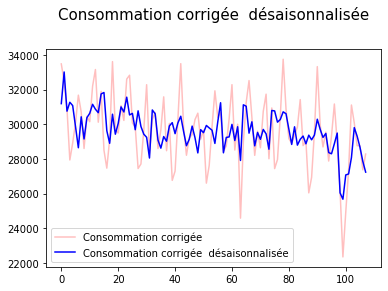

In [155]:
plt.plot(serie_corr_deseasonal["donnees_corriges"],'r', label="Consommation corrigée",alpha=0.25)
plt.plot(serie_corr_deseasonal['consommation_corr_des'],'b', label="Consommation corrigée  désaisonnalisée")
plt.title('Consommation corrigée  désaisonnalisée', fontsize=15, pad=30)
plt.savefig("P9_02_graphics/Consommation corrigée  désaisonnalisée.jpeg")
plt.legend()
plt.show()

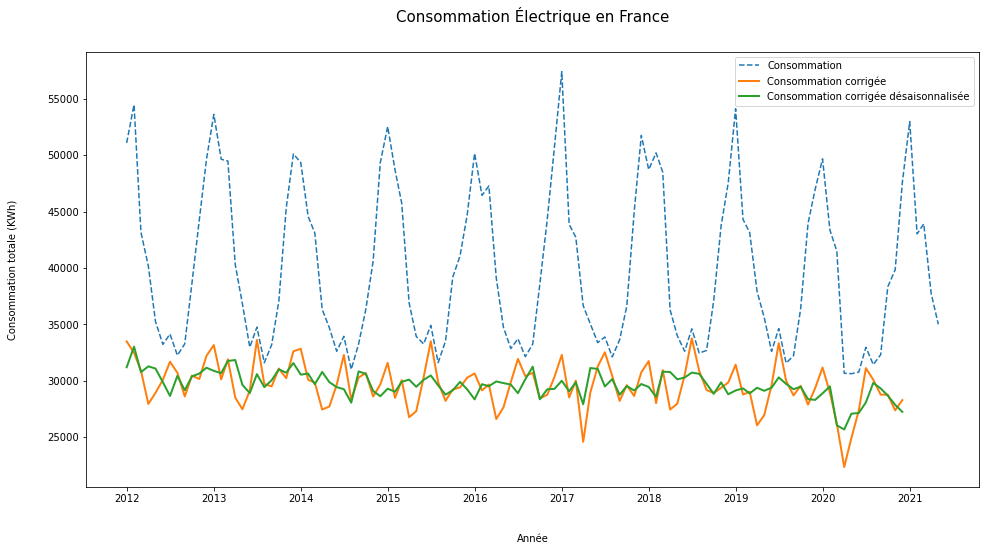

In [156]:
plt.figure(figsize=(16,8))

sns.lineplot(data=all_data, x='date', y='consommation', linestyle='dashed')
sns.lineplot(data=serie_corr_deseasonal, x='date', y='donnees_corriges', linewidth=2)
sns.lineplot(data=serie_corr_deseasonal, x='date', y='consommation_corr_des', linewidth=2)

plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (KWh)', labelpad=30)
plt.legend(labels=['Consommation', 'Consommation corrigée','Consommation corrigée désaisonnalisée'])
plt.title('Consommation Électrique en France', fontsize=15, pad=30)
plt.savefig("P9_02_graphics/Consommation_corrigée_désaisonnalisée.jpeg")

plt.show()

Nous avons récupéré les valeurs de chaque item grâce à la fonction et calvulé :

Conso(ajustee)cvs =  Conso(ajustee) - Saisonnalité


La moyenne mobile permet d'identifier la tendance qui est relativement stable jusqu'en 2020, puis plutôt décroissante par la suite.

# Mission 3
Prédiction
Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant Lissage exponentiel  -la méthode de Holt Winters  puis la méthode SARIMA sur la série temporelle.

Nous avons divisé cette mission de prédiction en deux parties. Pour commencer dans cette mission, nous devons prédire la consommation électrique en France sur 1 an après nos données.

Nous allons dans un premier temps utiliser la méthode de Holt-Winter, puis un modèle SARIMA.

Dans le cas de la méthode Holt-Winters, la saisonnalité de la série est prise en compte.

Cette méthode consiste à supposer que Xt est approximable au voisinage de T par :

            αT + (t-T)bT +  ST
            
En désignant par S la périod du cycle saisonnier de la série temporelle.

# Partie 1 : Holt-winter
Prédiction sur 12 mois de nos données corrigées de l'effet température.

In [157]:
all_data = all_data.reset_index()

In [158]:
all_data

,date,consommation,Chauffage,t
0,2012-01-01,51086,334.038,1
1,2012-02-01,54476,417.650,2
2,2012-03-01,43156,232.550,3
3,2012-04-01,40176,232.213,4
4,2012-05-01,35257,120.312,5
...,...,...,...,...
108,2021-01-01,52983,425.688,109
109,2021-02-01,43024,301.613,110
110,2021-03-01,43913,307.600,111
111,2021-04-01,37747,264.950,112


In [159]:
serie_corr_deseasonal

,date,donnees_corriges,consommation_corr_des
0,2012-01-01,33485.724,31192.900
1,2012-02-01,32470.221,33020.049
2,2012-03-01,30903.052,30758.527
3,2012-04-01,27940.835,31271.701
4,2012-05-01,28917.792,31081.061
...,...,...,...
103,2020-08-01,30082.441,29808.902
104,2020-09-01,28766.264,29315.575
105,2020-10-01,28754.362,28679.063
106,2020-11-01,27372.342,27859.583


In [160]:
merged_corr_data = pd.merge(all_data, serie_corr_deseasonal, on='date')

In [161]:
merged_corr_data

,date,consommation,Chauffage,t,donnees_corriges,consommation_corr_des
0,2012-01-01,51086,334.038,1,33485.724,31192.900
1,2012-02-01,54476,417.650,2,32470.221,33020.049
2,2012-03-01,43156,232.550,3,30903.052,30758.527
3,2012-04-01,40176,232.213,4,27940.835,31271.701
4,2012-05-01,35257,120.312,5,28917.792,31081.061
...,...,...,...,...,...,...
103,2020-08-01,31428,25.538,104,30082.441,29808.902
104,2020-09-01,32307,67.200,105,28766.264,29315.575
105,2020-10-01,38332,181.775,106,28754.362,28679.063
106,2020-11-01,39840,236.625,107,27372.342,27859.583


In [162]:
# on va suprimer 12 dernier mois
x_tronc = merged_corr_data.iloc[:-12,:]
#x_tronc = merged_corr_data

In [163]:
x_tronc

,date,consommation,Chauffage,t,donnees_corriges,consommation_corr_des
0,2012-01-01,51086,334.038,1,33485.724,31192.900
1,2012-02-01,54476,417.650,2,32470.221,33020.049
2,2012-03-01,43156,232.550,3,30903.052,30758.527
3,2012-04-01,40176,232.213,4,27940.835,31271.701
4,2012-05-01,35257,120.312,5,28917.792,31081.061
...,...,...,...,...,...,...
91,2019-08-01,31564,29.888,92,29989.242,29715.702
92,2019-09-01,32213,66.787,93,28693.999,29243.310
93,2019-10-01,36367,129.475,94,29545.024,29469.725
94,2019-11-01,43945,304.913,95,27879.306,28366.547


In [164]:
from statsmodels.tsa.api import ExponentialSmoothing

y= np.asarray(x_tronc["donnees_corriges"])
hw = ExponentialSmoothing(y, 
                          seasonal_periods=12, trend='add', 
                          seasonal='add').fit()
hw_pred = hw.forecast(12)

Modélisation
Lissage exponentiel Holt-Winters via la fonction ExponentialSmoothing avec une saisonnalité 12 

Prédiction pour l'année 2020
Grâce à la fonction forecast sur une périod 12

Comaraison avec les données réelles.

In [165]:
hw.params

{'smoothing_level': 0.08975756936596446,
 'smoothing_trend': 0.0014913604180159259,
 'smoothing_seasonal': 0.4774483877168589,
 'damping_trend': nan,
 'initial_level': 32187.002058826958,
 'initial_trend': -19.300343590910956,
 'initial_seasons': array([ 1326.97753728,   266.33725368, -1225.93161373, -4192.00472914,
        -3242.94843676, -2052.52832108,  -406.91163462, -1454.72197207,
        -3500.86760221, -1673.24393308, -1996.04662657,    47.02152983]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [166]:
pd.date_range(x_tronc.date[x_tronc.shape[0]-1],
                       periods=12, freq='M')

DatetimeIndex(['2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30'],
              dtype='datetime64[ns]', freq='M')

In [167]:
hw_pred

array([31116.47436992, 28131.85951782, 29279.70352112, 25877.67233743,
       27106.37102547, 29656.97287212, 32782.57453567, 29773.31410591,
       28382.91502994, 28823.5345924 , 27968.76911263, 29476.7262215 ])

In [168]:
x_a_prevoir = merged_corr_data.iloc[-12:,:]
x_a_prevoir['prediction']=hw_pred.copy()

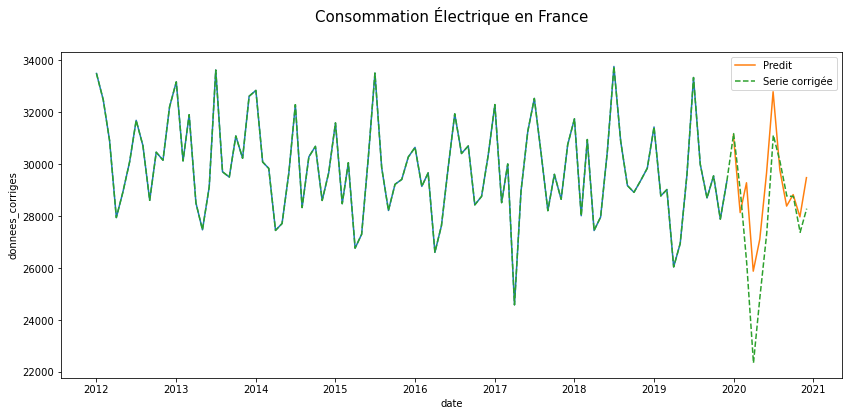

In [169]:
plt.figure(figsize=(14,6))
plt.plot(x_tronc['date'],x_tronc['donnees_corriges'])
plt.plot(pd.date_range(x_tronc.date[x_tronc.shape[0]-1],
                       periods=12, freq='M'), hw_pred, label='Predit')
sns.lineplot(data=merged_corr_data, x='date', y='donnees_corriges', linestyle='dashed',label='Serie corrigée')
plt.legend()
plt.title('Consommation Électrique en France', fontsize=15, pad=30)
plt.savefig("P9_02_graphics/consomation corrigée_predit.jpeg")


#plt.show()

Les données prédites via la méthode de lissage exponentiel, sur les moments passés de la série, sont relativement fidèles au données réelles test.


Pour vérifier la performance du modèle, nous allons calculer quelques métriques.

In [170]:
#Mean Absolute Error (MAE)

MAE=np.abs(x_a_prevoir['donnees_corriges']-x_a_prevoir['prediction']).mean()
MAE

1351.3634161884547

MAE – Mean Absolute Error

Mesure la déviation absolue moyenne entre une estilation prévue et les données réelles.


In [171]:
mape=(np.abs(1-x_a_prevoir['prediction']/x_a_prevoir['donnees_corriges'])).mean()*100
mape

5.184774253157063

MAPE – Mean Absolute Percentage Error

Moyenne des écarts en valeurs absolue par rapport aux valeurs observées exprimée en pourcentage.


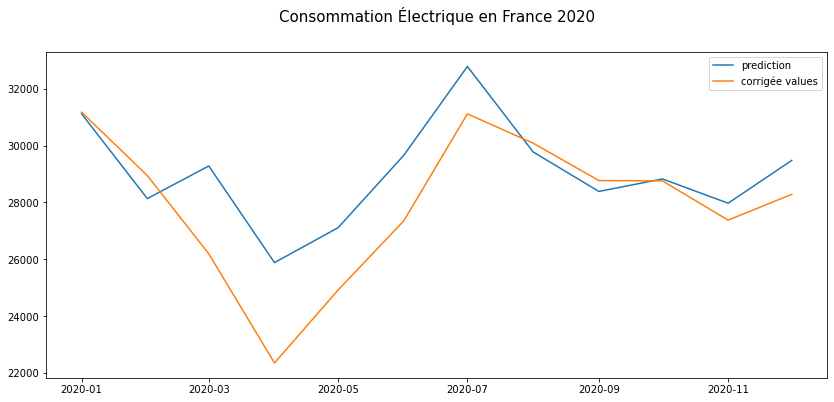

In [172]:
plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir['date'],x_a_prevoir['prediction'], label='prediction')
plt.plot(x_a_prevoir['date'],x_a_prevoir['donnees_corriges'], label='corrigée values')
plt.title('Consommation Électrique en France 2020', fontsize=15, pad=30)
plt.savefig("P9_02_graphics/consomation corrigé_predit.jpeg")
plt.legend()
plt.show()

On remarque que la saisonnalité et l'échelle des valeurs sont bien respectées.

# Partie 2 : SARIMA

LA méthod SARIMA ( Seasonnal AutoRegressive Integrated Moving Average ) permet de modéliser des séries qui présentent une saisonnalité, comme c'est la cas pour notre dataset.

Pour être certain que toutes les variables aléatoires suivent la même loi, nous allons devoir statinnariser la série.

 Nous stationnariserons notre série par différenciation.

A l'issue de la modélisation, il nous faudra obtenir un signal résiduel qui ne contient plus d'information temporelle, un bruit blanc qu'il faudra donc caractériser.

# Stationnarisation de la série

Prédiction sur 12 mois de nos données corrigées de l'effet température, avec un modèle SARIMA

In [173]:
def plot_sortie_acf( y_acf, y_len, pacf=False):
    "représentation de la sortie ACF"
    if pacf:
        y_acf = y_acf[1:]
    plt.figure(figsize=(14,6))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()
    return

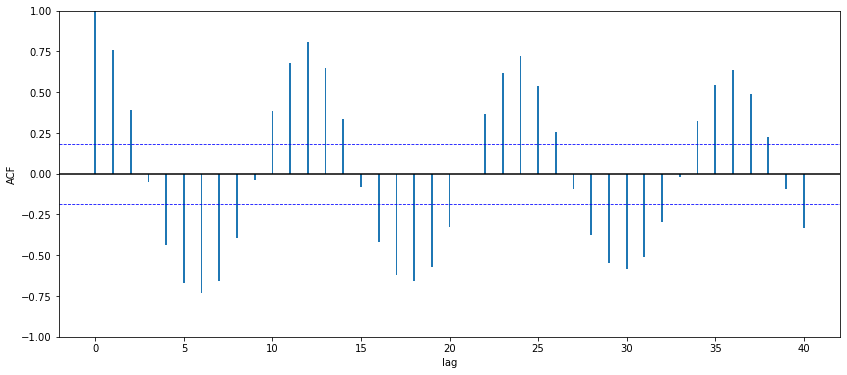

<Figure size 432x288 with 0 Axes>

In [174]:
serie_temporel = all_data

# variable nécessaire pour l'utilisation de plot_sortie_acf
y_len = len(serie_temporel['consommation']) 

plot_sortie_acf(acf(np.asarray(serie_temporel['consommation'])), y_len)

plt.savefig("P9_02_graphics/serie_temporel_consommation.jpeg")

plt.show()


Verification stationarité

In [175]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [176]:
adf_test(x_tronc['donnees_corriges'])

Results of Dickey-Fuller Test:
Test Statistic                -1.336
p-value                        0.612
#Lags Used                    11.000
Number of Observations Used   84.000
Critical Value (1%)           -3.511
Critical Value (5%)           -2.897
Critical Value (10%)          -2.585
dtype: float64


p-value for ADF test is 0.615 which is higher than 5%, so we keep the H0. And Thus 
we accept the hypothesis that the time series is non stationnary.

In [177]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


In [178]:
kpss_test(x_tronc['donnees_corriges'])

Results of KPSS Test:
Test Statistic          0.365
p-value                 0.092
Lags Used               1.000
Critical Value (10%)    0.347
Critical Value (5%)     0.463
Critical Value (2.5%)   0.574
Critical Value (1%)     0.739
dtype: float64


p-value for kpss test is 0.092 which is higher than 5%, so we keep the H0. And Thus 
we accept the hypothesis that the time series is non stationnary.

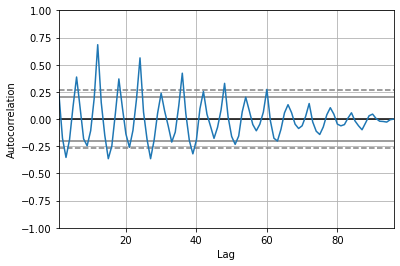

In [179]:

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(x_tronc['donnees_corriges'])

plt.savefig("P9_02_graphics/autocorrelation_plot.jpeg")
plt.show()

Avec ce plot on peut choisir combien lags il faut qu'on ait.

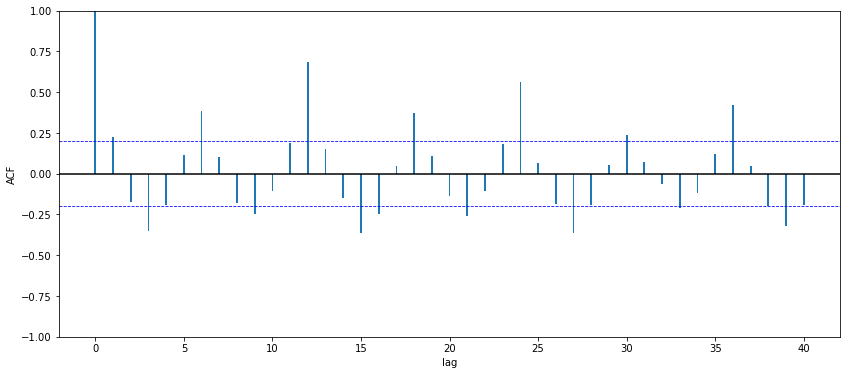

<Figure size 432x288 with 0 Axes>

In [180]:
from statsmodels.tsa.stattools import acf, pacf
from functions import plot_sortie_acf

y_len = len(x_tronc['donnees_corriges']) # variable nécessaire pour l'utilisation de plot_sortie_acf

plot_sortie_acf(acf(np.asarray(x_tronc['donnees_corriges'])), y_len)

plt.savefig("P9_02_graphics/x_tronc_données_corriges.jpeg")

plt.show()



In [181]:
x_tronc_diff_1 = x_tronc['donnees_corriges'] - x_tronc['donnees_corriges'].shift(1)

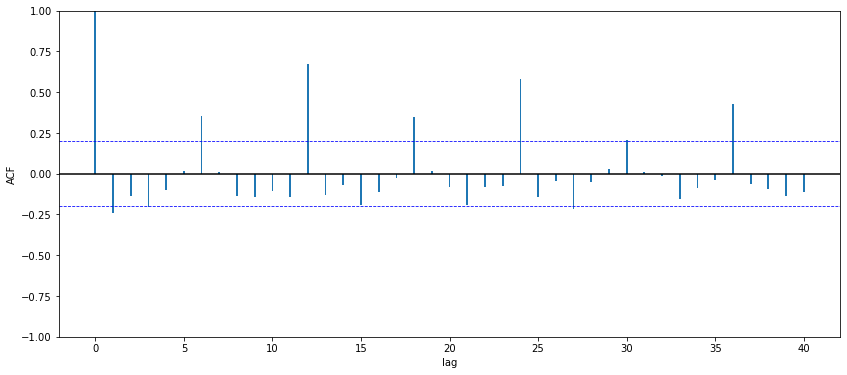

<Figure size 432x288 with 0 Axes>

In [182]:
plot_sortie_acf(acf(np.asarray(x_tronc_diff_1[1:,])), y_len)
plt.savefig("P9_02_graphics/x_tronc_données_corriges1.jpeg")
plt.show()

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation (𝐼−𝐵12) .

In [183]:
x_tronc_diff = x_tronc['donnees_corriges'] - x_tronc['donnees_corriges'].shift(12)

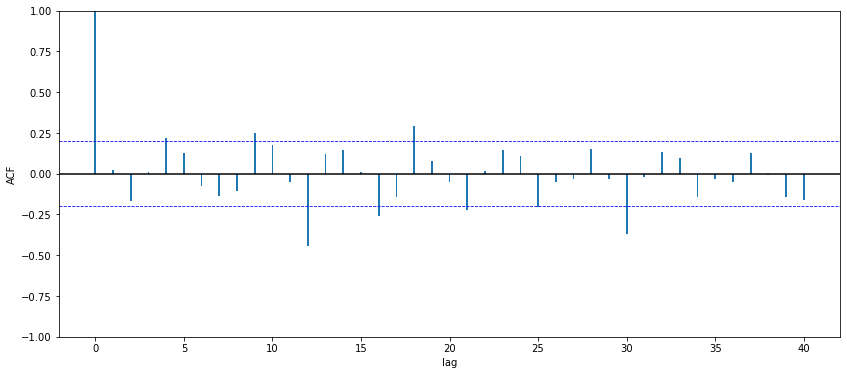

<Figure size 432x288 with 0 Axes>

In [184]:
plot_sortie_acf(acf(np.asarray(x_tronc_diff[12:,])), y_len)
plt.savefig("P9_02_graphics/x_tronc_données_corriges_annee.jpeg")
plt.show()

In [185]:
adf_test(x_tronc_diff[12:,])

Results of Dickey-Fuller Test:
Test Statistic                -2.523
p-value                        0.110
#Lags Used                    11.000
Number of Observations Used   72.000
Critical Value (1%)           -3.525
Critical Value (5%)           -2.903
Critical Value (10%)          -2.589
dtype: float64


In [186]:
#plot_sortie_acf(pacf(np.asarray(x_tronc_diff[12:,])), y_len)

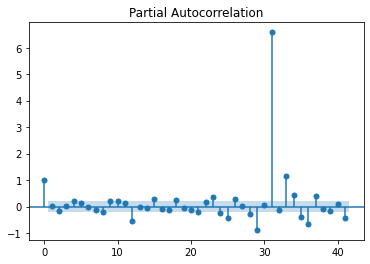

In [187]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.asarray(x_tronc_diff[12:,]), lags=41)
plt.savefig("P9_02_graphics/partial autocorrelation.jpeg")

plt.show()

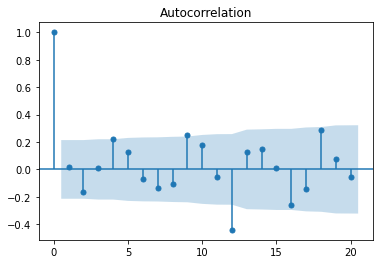

In [188]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.asarray(x_tronc_diff[12:,]))
plt.savefig("P9_02_graphics/autocorrelation.jpeg")
plt.show()

In [189]:
x_tronc

,date,consommation,Chauffage,t,donnees_corriges,consommation_corr_des
0,2012-01-01,51086,334.038,1,33485.724,31192.900
1,2012-02-01,54476,417.650,2,32470.221,33020.049
2,2012-03-01,43156,232.550,3,30903.052,30758.527
3,2012-04-01,40176,232.213,4,27940.835,31271.701
4,2012-05-01,35257,120.312,5,28917.792,31081.061
...,...,...,...,...,...,...
91,2019-08-01,31564,29.888,92,29989.242,29715.702
92,2019-09-01,32213,66.787,93,28693.999,29243.310
93,2019-10-01,36367,129.475,94,29545.024,29469.725
94,2019-11-01,43945,304.913,95,27879.306,28366.547


In [190]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(np.asarray(x_tronc["donnees_corriges"]), order=(1,0,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -705.532
Date:                            Sat, 19 Feb 2022   AIC                           1421.064
Time:                                    22:25:02   BIC                           1433.218
Sample:                                         0   HQIC                          1425.950
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7860      0.057    -13.820      0.000      -0.897      -0.675
ma.L1          0.9999      0.189   

Pas de trend sur les résidus (image haut gauche), ils semblent suivre une loi normale (image haut droite), le correlogram est bon (image bas droite), et la courbe est bonne (image bas gauche).

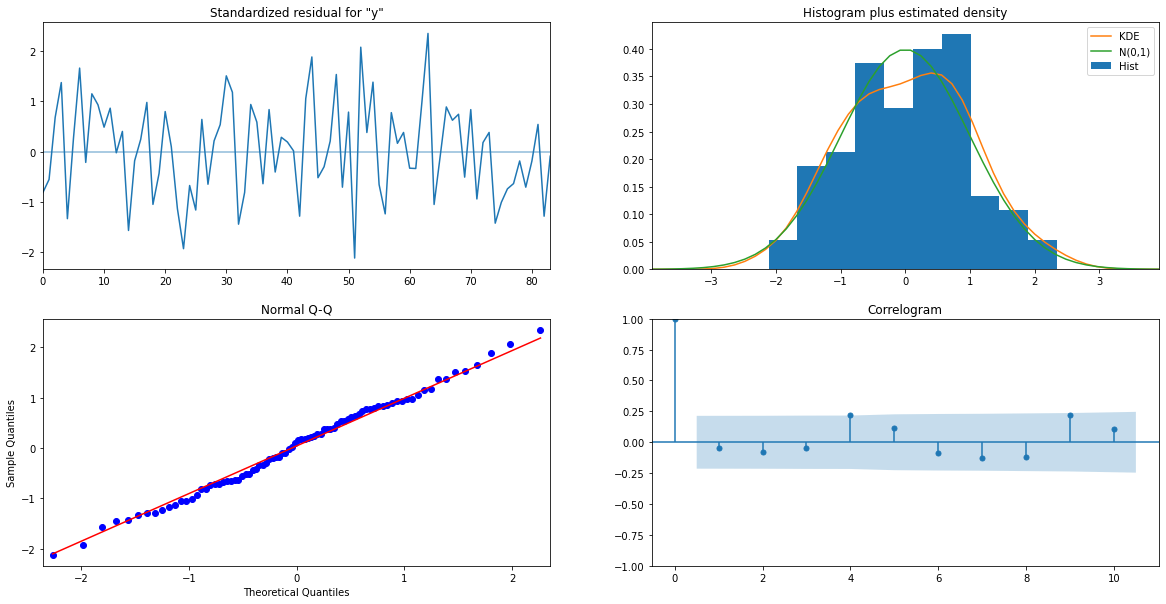

In [191]:

results1.plot_diagnostics(figsize=(20,10))
plt.savefig("P9_02_graphics/plot_diagnostics .jpeg")
plt.show()

In [192]:
pred_sarima = results1.forecast(12)
pred_sarima

array([31611.52231215, 28526.1591906 , 29141.88895087, 25885.83581656,
       27005.77406631, 29477.19921722, 33295.55244802, 29883.88668103,
       28676.91220197, 29446.11998707, 27876.4113873 , 29291.64697356])

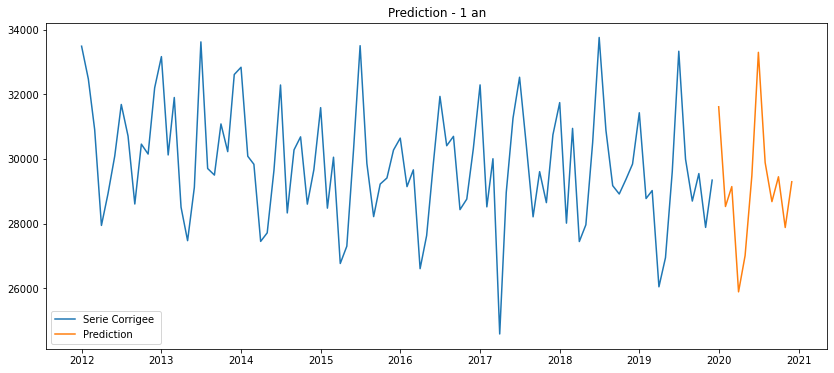

In [194]:
plt.figure(figsize=(14,6))
plt.plot(x_tronc['date'],x_tronc['donnees_corriges'], label='Serie Corrigee ')
plt.plot(pd.date_range(x_tronc.date[x_tronc.shape[0]-1],
                       periods=12, freq='M'), pred_sarima, label='Prediction')
plt.title('Prediction - 1 an')
plt.savefig("P9_02_graphics/prediction.jpeg")
plt.legend()
plt.show()

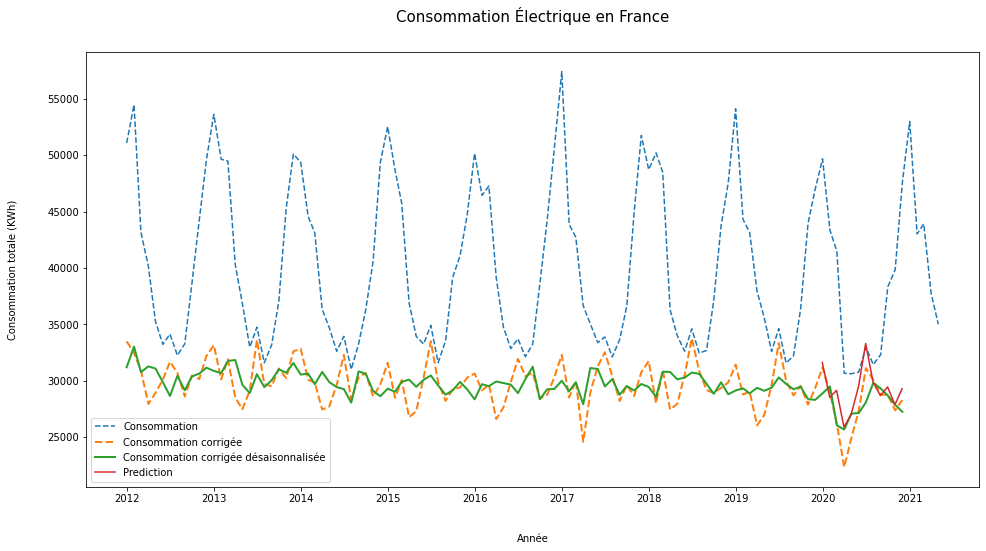

In [195]:
plt.figure(figsize=(16,8))

sns.lineplot(data=all_data, x='date', y='consommation', linestyle='dashed')
sns.lineplot(data=serie_corr_deseasonal, x='date', y='donnees_corriges', linestyle='dashed',linewidth=2)
sns.lineplot(data=serie_corr_deseasonal, x='date', y='consommation_corr_des', linewidth=2)
plt.plot(pd.date_range(x_tronc.date[x_tronc.shape[0]-1],
                       periods=12, freq='M'), pred_sarima, label='Prediction')

plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (KWh)', labelpad=30)
plt.legend(labels=['Consommation', 'Consommation corrigée','Consommation corrigée désaisonnalisée','Prediction'])
plt.title('Consommation Électrique en France', fontsize=15, pad=30)
plt.savefig("P9_02_graphics/Consommation Électrique en France.jpeg")
plt.show()

Les données prédites via la méthode SARIMA , sont là aussi relativement fidèles au données réelles.

In [196]:
mape=(np.abs(1-pred_sarima/x_a_prevoir['donnees_corriges'])).mean()*100
mape

5.163985602657941

In [197]:
#Mean Absolute Error (MAE)
MAE_sarima_model_optim=np.abs(x_a_prevoir['donnees_corriges']-pred_sarima).mean()
MAE_sarima_model_optim

1354.1162913763367


# MAE

The simplest measure of forecast accuracy is called Mean Absolute Error (MAE). Mean Absolute Error is simply, as the name suggests, the mean of the absolute errors. The absolute error is the absolute value of the difference between the forecasted value and the actual value. Mean Absolute Error measures accuracy for continuous variables. Both Mean Absolute Error and Root Mean Square Error express average model prediction error in units of the variable of interest. The Mean Absolute Error and the Root Mean Square Error can range from 0 to ∞ and are indifferent to the direction of errors.

# MAPE

MAPE (Mean Absolute Percentage Error)
The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a Loss function for regression problems in Machine Learning. The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms. 

# Conclusion
Notre modèle parvient à prédire des consommations plutôt juste, et les erreurs qui en ressortes sont assez minimes. Je pense donc que nous pouvons faire confiance à ces modèles.

2 méthodes permettant d ’obtenir des prédiction satisfaisantes.


Que ce soit par lissage exponentiel ou par méthode stochastique, les prédiction sont satisfaisantes et fidèles aux tendances de la série tepoirelle de consommation ajustée des effet de températures.

# Nous allons à présenter réaliser des prédiction pour les 12 prochaine mois avec Holt-Winters.


# Prédiction pour année 2021

In [198]:
from statsmodels.tsa.api import ExponentialSmoothing

y= np.asarray(serie_corr_deseasonal["donnees_corriges"])
hw = ExponentialSmoothing(y, 
                          seasonal_periods=12, trend='add', 
                          seasonal='add').fit()
hw_pred = hw.forecast(12)

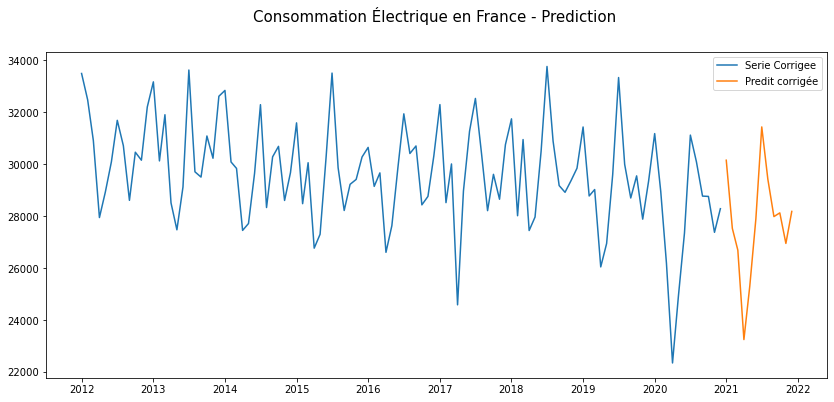

In [199]:
plt.figure(figsize=(14,6))
plt.plot(serie_corr_deseasonal['date'],serie_corr_deseasonal['donnees_corriges'], label='Serie Corrigee')
plt.plot(pd.date_range(serie_corr_deseasonal.date[len(y)-1],
                       periods=12, freq='M'), hw_pred, label='Predit corrigée')
plt.title('Consommation Électrique en France - Prediction ', fontsize=15, pad=30)
plt.savefig("P9_02_graphics/Consommation Électrique en France Prediction 2021.jpeg")
plt.legend()
plt.show()